In [71]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from common import Fonts, Images, NWSL, Colors, add_signature, Data

In [72]:
season = 2025

In [73]:
df = pd.read_csv("nwsl/" + str(season - 1) + "_" + str(season) + "_movement.csv")
df = (
    df.set_index("player")
    .join(
        Data.get_nwsl_player_stats(season=str(season-1))[["player", "mins_played"]]
        .groupby("player")
        .sum()
    )
    .sort_values("mins_played")
)
df

,team_old,team_new,mins_played
player,,,
Jenna Butler,WAS,NaN,1.0
Sinead Farrelly,GFC,NaN,1.0
Linda Motlhalo,LOU,NaN,3.0
Zoe Matthews,HOU,HOU,7.0
Landy Mertz,NC,NaN,7.0
...,...,...,...
Sydney Schneider,CHI,NaN,NaN
Taylor Huff,NaN,BAY,NaN
Trinity Armstrong,NaN,SD,NaN


In [58]:
# Drop players who aren't on new teams or have minutes
df = df.dropna(subset=["mins_played", "team_new"])
df

,team_old,team_new,mins_played
player,,,
Zoe Matthews,HOU,HOU,7.0
Jordan Brewster,BAY,BAY,9.0
Ángela Barón,LOU,LOU,12.0
Mallie McKenzie,POR,POR,12.0
Chloe Ricketts,WAS,WAS,18.0
...,...,...,...
Kaleigh Kurtz,NC,NC,2340.0
Kate Del Fava,UTA,UTA,2340.0
Katie Lund,LOU,LOU,2340.0


In [60]:
# To confirm if players are missing
missing_minutes = set(df[df["mins_played"].isna()].index)
signed = set(pd.read_csv("nwsl/signed.csv")["player"])
missing_minutes - signed

set()

In [61]:
df_agg = (
    df.reset_index().drop(columns=["player"]).groupby(["team_new", "team_old"]).sum()
)
df_agg

mins_played
team_new team_old             
BAY      BAY           20792.0
         POR            1719.0
CHI      CHI           21764.0
         GFC             405.0
GFC      GFC           14633.0
         POR            1890.0
         RGN            1177.0
HOU      GFC            4051.0
         HOU           19612.0
         LA              679.0
         ORL             174.0
         SD             2283.0
KCC      KCC           22989.0
         LA             1139.0
         NC             1469.0
         RGN             750.0
LA       BAY            1109.0
         LA            15989.0
LOU      LOU           22377.0
NC       NC            20998.0
         SD             1252.0
         UTA            1674.0
ORL      ORL           24876.0
POR      BAY            1060.0
         GFC            1115.0
         POR           18362.0
         SD              513.0
RGN      GFC            1280.0
         LA             1595.0
         RGN           17072.0
SD       LA             2070.0
         SD            14098.0
UTA      BAY             296.0
         CHI            1133.0
         NC              766.0
         UTA           19856.0
WAS      NC             1967.0
         WAS           23601.0

In [62]:
df_total = (
    df.groupby("team_new")
    .agg(total_mins=("mins_played", "sum"))
    .sort_values("total_mins", ascending=False)
)
df_total

,total_mins
team_new,
HOU,26799.0
KCC,26347.0
WAS,25568.0
ORL,24876.0
NC,23924.0
BAY,22511.0
LOU,22377.0
CHI,22169.0
UTA,22051.0


In [63]:
df_self = df_agg.reset_index()
df_self = df_total.join(
    df_self[df_self["team_new"] == df_self["team_old"]].set_index("team_new")
).reset_index()[["team_old", "team_new", "mins_played", "total_mins"]]
df_self

,team_old,team_new,mins_played,total_mins
0,HOU,HOU,19612.0,26799.0
1,KCC,KCC,22989.0,26347.0
2,WAS,WAS,23601.0,25568.0
3,ORL,ORL,24876.0,24876.0
4,NC,NC,20998.0,23924.0
5,BAY,BAY,20792.0,22511.0
6,LOU,LOU,22377.0,22377.0
7,CHI,CHI,21764.0,22169.0
8,UTA,UTA,19856.0,22051.0
9,POR,POR,18362.0,21050.0


In [64]:
def get_data_for_team(old_team):
    result = []
    for team in df_self["team_new"]:
        if (team, old_team) in df_agg.index and team != old_team:
            result.append(df_agg.loc[(team, old_team), "mins_played"])
        else:
            result.append(0)
    return result

<Figure size 6400x4000 with 0 Axes>

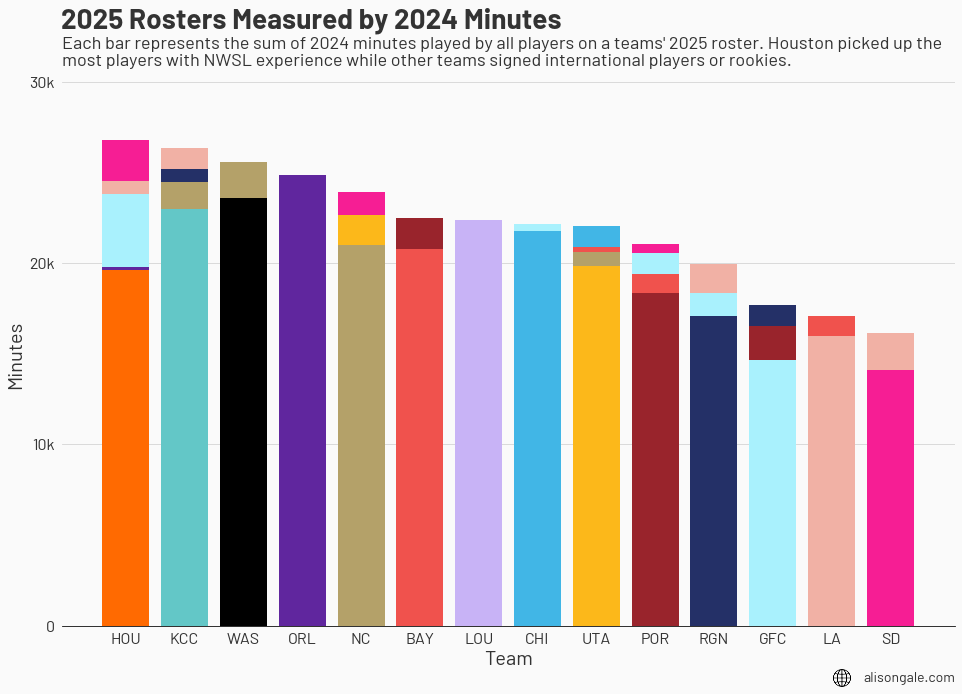

In [76]:
# Set up plot
plt.rcParams["figure.figsize"] = (16, 10)
plt.figure(dpi=400)
fig, ax = plt.subplots()
fig.patch.set_facecolor(Colors.WHITE)
ax.set_facecolor(Colors.WHITE)

# Plot data

# Start with the home team data
bottom = np.zeros(len(df_self.index))
plt.bar(
    df_self["team_new"],
    df_self["mins_played"],
    color=list(map(lambda x: NWSL.color(x), df_self["team_old"])),
    bottom=bottom,
)
bottom += df_self["mins_played"]

# Render all other teams on top
for team in df_self["team_old"]:
    minutes = get_data_for_team(team)
    plt.bar(
        df_self["team_new"],
        minutes,
        color=list(map(lambda x: NWSL.color(team), minutes)),
        bottom=bottom,
    )
    bottom += minutes

# Axes
ax.set_ylim([0, 30000])
ax.set_yticks([0, 10000, 20000, 30000])
ax.set_yticklabels(["0", "10k", "20k", "30k"])
ax.spines[["top", "right", "left"]].set_visible(False)
ax.tick_params(bottom=False, left=False)
ax.yaxis.grid(True, color=Colors.LIGHT_GRAY)
ax.set_axisbelow(True)
ax.tick_params(axis="both", which="major", labelsize=16, labelcolor=Colors.BLACK)
for label in ax.get_yticklabels() + ax.get_xticklabels():
    fp = Fonts.BARLOW
    fp.set_size(16)
    label.set_fontproperties(fp)

# Axis labels
ax.set_xlabel(
    "Team",
    fontproperties=Fonts.BARLOW,
    color=Colors.BLACK,
    size=20,
)
ax.set_ylabel(
    "Minutes",
    fontproperties=Fonts.BARLOW,
    color=Colors.BLACK,
    size=20,
)

# Title
ax.text(
    -1.1,
    33000,
    str(season) + " Rosters Measured by " + str(season - 1) + " Minutes",
    fontproperties=Fonts.BARLOW_BOLD,
    color=Colors.BLACK,
    size=28,
    ha="left",
)

# Subtitle
fig.text(
    0,
    1.03,
    "Each bar represents the sum of 2024 minutes played by all players on a teams' 2025 roster. Houston picked up the\nmost players with NWSL experience while other teams signed international players or rookies.",
    fontproperties=Fonts.BARLOW,
    size=18,
    transform=ax.transAxes,
    ha="left",
    color=Colors.BLACK,
)

# Twitter logo and username
add_signature(fig, x=0.79, y=0.04, fs=14, w=0.025)

# Save image
plt.savefig(
    "images/" + str(season) + "_offseason_minutes.png",
    bbox_inches="tight",
    pad_inches=0.5,
    dpi=400,
)